In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, read_csv
from pandas.plotting import autocorrelation_plot, lag_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from machine_learning.signals.lstmer import init_univariate_model, ModelConfigs, TrainConfigs, train
from machine_learning.signals.utils import stack_windows
from machine_learning.utils.utils_metric import mape, rmse

In [3]:
plt.style.use('seaborn-whitegrid')
sns.set_color_codes()

figsize = (8, 6)

### airline-passengers dataset

In [4]:
filepath = "airline_passengers.csv"
dataset = read_csv(filepath, usecols=[1], engine="python")
dataset.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [5]:
series = dataset["Passengers"]

<AxesSubplot:>

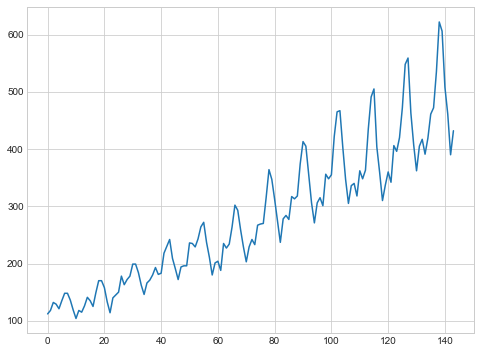

In [6]:
series.plot(figsize=figsize)

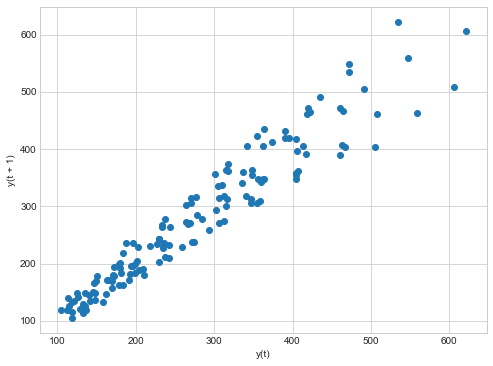

In [7]:
plt.figure(figsize=figsize)
lag_plot(series)
plt.show()

In [8]:
values = series.values

In [9]:
np.corrcoef(np.vstack([values[0:-1], values[1:]]))

array([[1.        , 0.96019465],
       [0.96019465, 1.        ]])

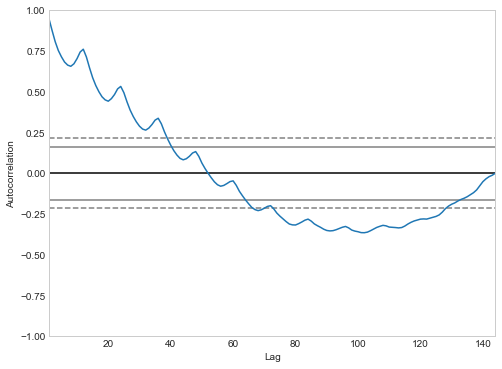

In [10]:
plt.figure(figsize=figsize)
autocorrelation_plot(values)
plt.show()

### preprocessing

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values.reshape(-1, 1))

In [12]:
train_size = 0.7
train_obs, test_obs = train_test_split(values, train_size=train_size, shuffle=False)

### some common params

In [13]:
loss = "mean_squared_error"
optimizer = "adam"
batch_size = 10
n_epochs = 100
verbose = 2

In [14]:
configs = TrainConfigs(loss=loss, 
                       optimizer=optimizer, 
                       n_epochs=n_epochs, 
                       verbose=verbose, 
                      )

## previous timesteps obs are used as 1 sample of timesteps features to predict subsequent obs

### timesteps = 1, n_lstm_layers = 1

In [15]:
timesteps = 1
obs_as_timesteps = False

In [16]:
X_train, Y_train = stack_windows(train_obs, timesteps, obs_as_timesteps)
X_test, Y_test = stack_windows(test_obs, timesteps, obs_as_timesteps)

#### modeling

In [18]:
n_units = 4
n_lstm_layers = 1
stateful = False

model_configs = ModelConfigs(timesteps=timesteps, 
                             obs_as_timesteps=obs_as_timesteps, 
                             n_units=n_units, 
                             n_lstm_layers=n_lstm_layers, 
                             stateful=stateful, 
                             batch_size=batch_size,
                             )

In [20]:
model = init_univariate_model(**model_configs.dict())

2022-03-14 10:13:06.649841: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model = train(configs, model, X_train, Y_train)

10/10 - 1s - loss: 0.0880 - 1s/epoch - 133ms/step
10/10 - 0s - loss: 0.0791 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0710 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0641 - 14ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0579 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0522 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0476 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0433 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0397 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0364 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0337 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0312 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0292 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0274 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0260 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0249 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0240 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0232 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0226 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0220 - 11ms/epoch - 1ms/step


#### predicting

In [22]:
Y_train_pred = model.predict(X_train)
Y_train_pred = scaler.inverse_transform(Y_train_pred)
Y_train = scaler.inverse_transform(Y_train)

In [23]:
rmse(Y_train, Y_train_pred), mape(Y_train, Y_train_pred)

(35.959993593843144, 0.15697768197986972)

In [24]:
Y_test_pred = model.predict(X_test)
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_test = scaler.inverse_transform(Y_test)

In [25]:
rmse(Y_test, Y_test_pred), mape(Y_test, Y_test_pred)

(83.52484941198189, 0.15481675650459126)

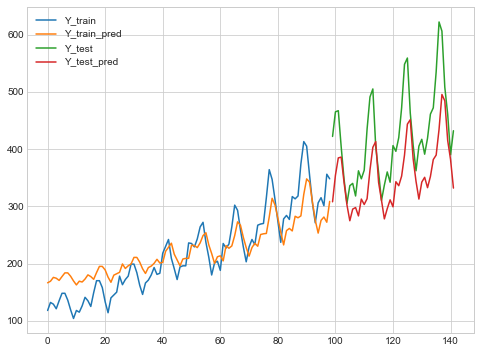

In [26]:
n_Y_train = len(Y_train)
n_Y_test = len(Y_test)

plt.figure(figsize=figsize)
plt.plot(Y_train, label="Y_train")
plt.plot(Y_train_pred, label="Y_train_pred")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test, label="Y_test")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test_pred, label="Y_test_pred")
plt.legend()
plt.show()

### timesteps = 3, n_lstm_layers = 1

In [27]:
timesteps = 3
obs_as_timesteps = False

In [28]:
X_train, Y_train = stack_windows(train_obs, timesteps, obs_as_timesteps)
X_test, Y_test = stack_windows(test_obs, timesteps, obs_as_timesteps)

#### modeling

In [29]:
n_units = 4
n_lstm_layers = 1
stateful = False

model_configs = ModelConfigs(timesteps=timesteps, 
                             obs_as_timesteps=obs_as_timesteps, 
                             n_units=n_units, 
                             n_lstm_layers=n_lstm_layers, 
                             stateful=stateful, 
                             batch_size=batch_size,
                             )

In [30]:
model = init_univariate_model(**model_configs.dict())

In [31]:
model = train(configs, model, X_train, Y_train)

10/10 - 1s - loss: 0.0509 - 1s/epoch - 137ms/step
10/10 - 0s - loss: 0.0435 - 14ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0363 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0305 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0254 - 14ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0212 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0177 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0152 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0132 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0117 - 13ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0107 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0098 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0092 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0089 - 11ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0085 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0082 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0080 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0078 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0076 - 12ms/epoch - 1ms/step
10/10 - 0s - loss: 0.0074 - 11ms/epoch - 1ms/step


#### predicting

In [32]:
Y_train_pred = model.predict(X_train)
Y_train_pred = scaler.inverse_transform(Y_train_pred)
Y_train = scaler.inverse_transform(Y_train)

In [33]:
rmse(Y_train, Y_train_pred), mape(Y_train, Y_train_pred)

(28.223775278764975, 0.09759910883180341)

In [34]:
Y_test_pred = model.predict(X_test)
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_test = scaler.inverse_transform(Y_test)

In [35]:
rmse(Y_test, Y_test_pred), mape(Y_test, Y_test_pred)

(62.488699456064616, 0.11457903360400624)

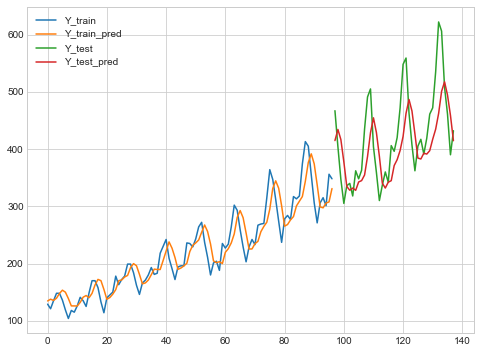

In [36]:
n_Y_train = len(Y_train)
n_Y_test = len(Y_test)

plt.figure(figsize=figsize)
plt.plot(Y_train, label="Y_train")
plt.plot(Y_train_pred, label="Y_train_pred")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test, label="Y_test")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test_pred, label="Y_test_pred")
plt.legend()
plt.show()

## previous timesteps obs are used as timesteps samples of 1 feature to predict subsequent obs

### timesteps = 3, n_lstm_layers = 2

In [37]:
timesteps = 3
obs_as_timesteps = True

In [38]:
X_train, Y_train = stack_windows(train_obs, timesteps, obs_as_timesteps)
X_test, Y_test = stack_windows(test_obs, timesteps, obs_as_timesteps)

#### modeling

In [39]:
n_units = 4
n_lstm_layers = 2
stateful = False

model_configs = ModelConfigs(timesteps=timesteps, 
                             obs_as_timesteps=obs_as_timesteps, 
                             n_units=n_units, 
                             n_lstm_layers=n_lstm_layers, 
                             stateful=stateful, 
                             batch_size=batch_size,
                             )

In [40]:
model = init_univariate_model(**model_configs.dict())

In [41]:
model = train(configs, model, X_train, Y_train)

10/10 - 2s - loss: 0.0728 - 2s/epoch - 244ms/step
10/10 - 0s - loss: 0.0617 - 32ms/epoch - 3ms/step
10/10 - 0s - loss: 0.0518 - 35ms/epoch - 3ms/step
10/10 - 0s - loss: 0.0432 - 24ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0357 - 26ms/epoch - 3ms/step
10/10 - 0s - loss: 0.0292 - 25ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0244 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0209 - 24ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0188 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0176 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0170 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0167 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0162 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0159 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0154 - 21ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0149 - 22ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0144 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0139 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0133 - 23ms/epoch - 2ms/step
10/10 - 0s - loss: 0.0128 - 26ms/epoch - 3ms/step


#### predicting

In [42]:
Y_train_pred = model.predict(X_train)
Y_train_pred = scaler.inverse_transform(Y_train_pred)
Y_train = scaler.inverse_transform(Y_train)

In [43]:
rmse(Y_train, Y_train_pred), mape(Y_train, Y_train_pred)

(35.37880816582205, 0.12570190937464878)

In [44]:
Y_test_pred = model.predict(X_test)
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_test = scaler.inverse_transform(Y_test)

In [45]:
rmse(Y_test, Y_test_pred), mape(Y_test, Y_test_pred)

(77.30734727599608, 0.14389315743892853)

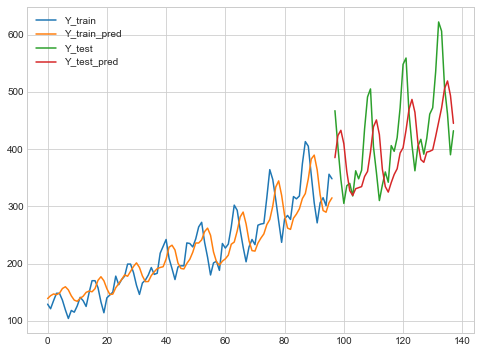

In [46]:
n_Y_train = len(Y_train)
n_Y_test = len(Y_test)

plt.figure(figsize=figsize)
plt.plot(Y_train, label="Y_train")
plt.plot(Y_train_pred, label="Y_train_pred")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test, label="Y_test")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test_pred, label="Y_test_pred")
plt.legend()
plt.show()

## while keeping state/memory during each epoch, i.e. through the batches

In [47]:
X_train, Y_train = stack_windows(train_obs, timesteps, obs_as_timesteps)
X_test, Y_test = stack_windows(test_obs, timesteps, obs_as_timesteps)

#### modeling

In [48]:
n_units = 4
n_lstm_layers = 1
stateful = True
batch_size = 1  # must divide train size so that all batches have the same size to keep state/memory

model_configs = ModelConfigs(timesteps=timesteps, 
                             obs_as_timesteps=obs_as_timesteps, 
                             n_units=n_units, 
                             n_lstm_layers=n_lstm_layers, 
                             stateful=stateful, 
                             batch_size=batch_size,
                             )

In [49]:
model = init_univariate_model(**model_configs.dict())

In [50]:
model = train(configs, model, X_train, Y_train)

97/97 - 1s - loss: 0.0258 - 1s/epoch - 11ms/step
97/97 - 0s - loss: 0.0182 - 99ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0143 - 102ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0102 - 98ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0070 - 97ms/epoch - 995us/step
97/97 - 0s - loss: 0.0052 - 97ms/epoch - 995us/step
97/97 - 0s - loss: 0.0047 - 96ms/epoch - 989us/step
97/97 - 0s - loss: 0.0046 - 97ms/epoch - 999us/step
97/97 - 0s - loss: 0.0046 - 101ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0045 - 98ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0045 - 95ms/epoch - 978us/step
97/97 - 0s - loss: 0.0045 - 97ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0045 - 97ms/epoch - 998us/step
97/97 - 0s - loss: 0.0045 - 97ms/epoch - 996us/step
97/97 - 0s - loss: 0.0045 - 96ms/epoch - 990us/step
97/97 - 0s - loss: 0.0045 - 97ms/epoch - 997us/step
97/97 - 0s - loss: 0.0044 - 96ms/epoch - 990us/step
97/97 - 0s - loss: 0.0044 - 96ms/epoch - 989us/step
97/97 - 0s - loss: 0.0044 - 99ms/epoch - 1ms/step
97/97 - 0s - loss: 0.0044 -

#### predicting

In [51]:
# state for sample i in batch is kept for sample i in next batch, hence batch_size must be given 
Y_train_pred = model.predict(X_train, batch_size=batch_size)
Y_train_pred = scaler.inverse_transform(Y_train_pred)
Y_train = scaler.inverse_transform(Y_train)

In [52]:
rmse(Y_train, Y_train_pred), mape(Y_train, Y_train_pred)

(26.362784696390218, 0.09471959808295854)

In [53]:
model.reset_states()
Y_test_pred = model.predict(X_test, batch_size=batch_size)
model.reset_states()
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_test = scaler.inverse_transform(Y_test)

In [54]:
rmse(Y_test, Y_test_pred), mape(Y_test, Y_test_pred)

(64.58199352569734, 0.10760989151572238)

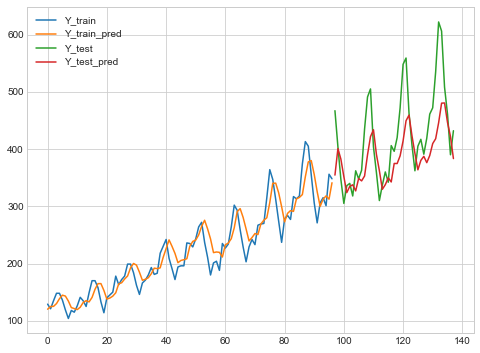

In [55]:
n_Y_train = len(Y_train)
n_Y_test = len(Y_test)

plt.figure(figsize=figsize)
plt.plot(Y_train, label="Y_train")
plt.plot(Y_train_pred, label="Y_train_pred")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test, label="Y_test")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test_pred, label="Y_test_pred")
plt.legend()
plt.show()

## stacking LSTM layers while keeping state/memory during each epoch, i.e. through the batches
stacked LSTM layers are easier to train than stacked RNN layers

In [56]:
X_train, Y_train = stack_windows(train_obs, timesteps, obs_as_timesteps)
X_test, Y_test = stack_windows(test_obs, timesteps, obs_as_timesteps)

#### modeling

In [57]:
n_units = 4
n_lstm_layers = 2
stateful = True

model_configs = ModelConfigs(timesteps=timesteps, 
                             obs_as_timesteps=obs_as_timesteps, 
                             n_units=n_units, 
                             n_lstm_layers=n_lstm_layers, 
                             stateful=stateful, 
                             batch_size=batch_size,
                             )

In [58]:
model = init_univariate_model(**model_configs.dict())

In [59]:
model = train(configs, model, X_train, Y_train)

97/97 - 2s - loss: 0.0071 - 2s/epoch - 21ms/step
97/97 - 0s - loss: 0.0265 - 169ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0148 - 155ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0107 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0084 - 150ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0074 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0070 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0068 - 150ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0067 - 146ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0066 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0065 - 150ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0064 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0063 - 151ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0063 - 151ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0062 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0061 - 149ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0060 - 155ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0059 - 152ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0059 - 148ms/epoch - 2ms/step
97/97 - 0s - loss: 0.0058 - 155ms

#### predicting

In [60]:
# state for sample i in batch is kept for sample i in next batch, hence batch_size must be given 
Y_train_pred = model.predict(X_train, batch_size=batch_size)
Y_train_pred = scaler.inverse_transform(Y_train_pred)
Y_train = scaler.inverse_transform(Y_train)

In [61]:
rmse(Y_train, Y_train_pred), mape(Y_train, Y_train_pred)

(22.183154516632705, 0.08789715865841131)

In [62]:
model.reset_states()
Y_test_pred = model.predict(X_test, batch_size=batch_size)
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_test = scaler.inverse_transform(Y_test)

In [63]:
rmse(Y_test, Y_test_pred), mape(Y_test, Y_test_pred)

(63.712671700940874, 0.11365543294542152)

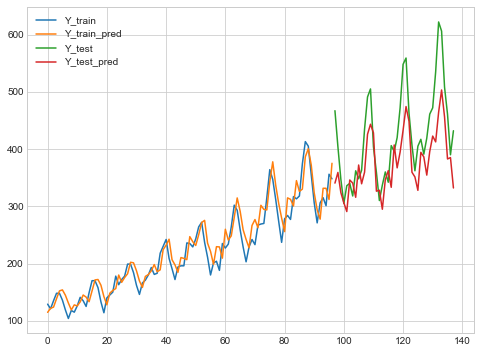

In [64]:
n_Y_train = len(Y_train)
n_Y_test = len(Y_test)

plt.figure(figsize=figsize)
plt.plot(Y_train, label="Y_train")
plt.plot(Y_train_pred, label="Y_train_pred")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test, label="Y_test")
plt.plot(range(n_Y_train, n_Y_train + n_Y_test), Y_test_pred, label="Y_test_pred")
plt.legend()
plt.show()